In [167]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import json
from json import JSONEncoder
import h5py
import csv

In [168]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [173]:
# get sample tracings
filename = "../../data/ecg_tracings.hdf5"

data = None

with h5py.File(filename, "r") as f:
    # List all groups
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

nd_data = np.asarray(data)
nd_data_50 = nd_data[:50]
nd_data_20 = nd_data[:20]
print(nd_data_50.shape)

(50, 4096, 12)


In [193]:
# visualize ECG data
print(nd_data_50.max())
print(nd_data_50.min())
print(nd_data_50.mean())

one_ecg = nd_data_50[0]
swap_ecg_0 = np.swapaxes(one_ecg, 0, 1)
leads_len = swap_ecg.shape[0]
data_len = swap_ecg.shape[1]

titles = ['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def save_ecgs(ecg_num):
    for i in range(ecg_num):
        for j in range(12):
            swap_ecg = np.swapaxes(nd_data_50[i], 0, 1)
            y_ecg_plot = swap_ecg[j]
            x_time = range(data_len)
            sizes = [10 for n in range(data_len)]

            # plt.scatter(x_time, y_ecg_plot, c="red")
            fig = plt.figure()
            plt.plot(x_time, y_ecg_plot, '-0')
            plt.title(titles[j], color='#FFFFFF')

            ax = plt.gca()
            ax.set_ylim([-5, 5])

            ax.xaxis.set_major_locator(MultipleLocator(100))
            ax.yaxis.set_major_locator(MultipleLocator(0.35))
            ax.set_yticklabels([])
            ax.set_xticklabels([])

            plt.grid(which='major', color='#D39191', linestyle='-')
#             plt.show()
            fig.savefig("./ecg-imgs/ecg_" + str(i) + "_" + str(j) + ".png")
            plt.close()

save_ecgs(50)

16.715126065770466
-8.132808492374114
-0.05628314906933864


In [174]:
# save tracings in json file

# JSON Serialization for expediency of demo
npData = {}
sampleSize = nd_data_20.shape[0]
for i in range(sampleSize):
    ecg_data = nd_data_50[i]
    npData[i] = ecg_data
encodeNpData = json.dumps(npData, cls=NumpyArrayEncoder)  # use dump() to write array into file
with open('sample_tracings.json', 'w') as json_file:
    json.dump(encodeNpData, json_file)

In [51]:
# get patient data
# Function to convert a CSV to JSON
# Takes the file paths as arguments
def make_json(csvFilePath, jsonFilePath):
     
    # create a dictionary
    data = {}
     
    # Open a csv reader called DictReader
    with open(csvFilePath, encoding='utf-8') as csvf:
        csvReader = csv.DictReader(csvf)
         
        # Convert each row into a dictionary
        # and add it to data
        for index, rows in enumerate(csvReader):
             
            # Assuming a column named 'No' to
            # be the primary key
            key = int(index)
            data[key] = rows
 
    # Open a json writer, and use the json.dumps()
    # function to dump data
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(data, indent=4))
         
# Driver Code
 
# Decide the two file paths according to your
# computer system
csvFilePath = r'attributes.csv'
jsonFilePath = r'attributes.json'
 
# Call the make_json function
make_json(csvFilePath, jsonFilePath)


In [23]:
# the labels are:
# 1st degree AV block
# Right bundle branch block
# Left bundle branch block
# Sinus bradycardia
# Atrial fibrillation
# Sinus tachycardia
# Normal
x_label = ['1dAVb','RBBB','LBBB','SB','AF','ST', 'Normal']

In [24]:
output = np.load('test1.npy')
N = len(output)

In [25]:
ground_truth = np.genfromtxt('gold_standard.csv', delimiter=',')
ground_truth = ground_truth[1:]

In [26]:
# add a column in the end of dataset that represents 'normal ecg'
# this column is binary, it will be 1 if all values in a result are below the threshold, and 0 otherwise
def add_normal_column(threshold, dataset):
    f = lambda x: 1 if x < threshold else 0
    above_thresh = np.vectorize(f) 
    
    new_col = np.amax(dataset, axis=1)
    new_col = np.expand_dims(above_thresh(new_col), axis=1)
    return np.append(dataset, new_col, axis=1)

In [27]:
# add normal column to output and ground truth
threshold = 0.12
output = add_normal_column(threshold, output)
ground_truth = add_normal_column(threshold, ground_truth)
print(output.shape)
print(ground_truth.shape)

print(output[15])


(827, 7)
(827, 7)
[1.96125299e-01 1.49503350e-03 6.91953301e-01 1.92937255e-03
 1.69748873e-01 4.82499599e-04 0.00000000e+00]


In [28]:
# False positive / negative rate in the test data set
false_pos = []
false_neg = []
for i in range(N):
    if output[i][6] != ground_truth[i][6]:
        if output[i][6] > ground_truth[i][6]:
            false_neg.append(i)
        else:
            false_pos.append(i)

false_pos_num = len(false_pos)
false_pos_perc = false_pos_num / N

false_neg_num = len(false_neg)
false_neg_perc = false_neg_num / N

accuracy = (N - false_pos_num - false_neg_num) / N

print('False positives: {num}, {perc:.2f}%'.format(num=false_pos_num, perc=false_pos_perc * 100))
print(false_pos)
print('False negatives: {num}, {perc:.2f}%'.format(num=false_neg_num, perc=false_neg_perc * 100))
print(false_neg)
print('Overall accuracy: {perc:.2f}%'.format(perc=accuracy * 100))


False positives: 12, 1.45%
[22, 121, 356, 422, 438, 502, 505, 645, 646, 678, 681, 728]
False negatives: 8, 0.97%
[57, 151, 313, 341, 355, 367, 720, 758]
Overall accuracy: 97.58%


In [59]:
# JSON Serialization for expediency of demo
numpyData = {}
for i, d in enumerate(output):
    numpyData[i] = d
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)  # use dump() to write array into file
with open('sample_output.json', 'w') as json_file:
    json.dump(encodedNumpyData, json_file)

# print("Printing JSON serialized NumPy array")
# print(encodedNumpyData)

In [9]:
# plot sample prediction
def plot_prediction(sample_num):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    X = np.arange(7)
    y_prediction_values = output[sample_num]
    y_ground_truth = ground_truth[sample_num]

    ax.bar(X - 0.125, y_ground_truth, width=0.25)
    ax.bar(X + 0.125, y_prediction_values, width=0.25)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(X)
    ax.set_xticklabels(x_label)
    ax.legend(['ground truth', 'prediction'])
    
    plt.title('DNN prediction vs. ground truth for test sample #' + str(sample_num))
    plt.xlabel('Abnormality')
    plt.ylabel('Percent confidence')
    plt.show()
    
    
def get_prediction(sample_num):
    return output[sample_num]

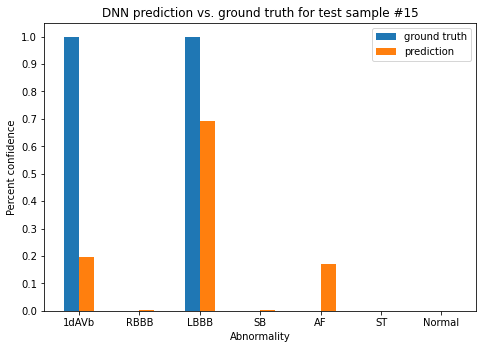

array([1.96125299e-01, 1.49503350e-03, 6.91953301e-01, 1.92937255e-03,
       1.69748873e-01, 4.82499599e-04, 0.00000000e+00])

In [10]:
plot_prediction(15)
get_prediction(15)

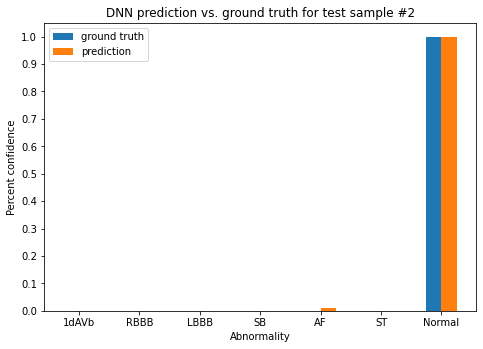

In [195]:
plot_prediction(2)

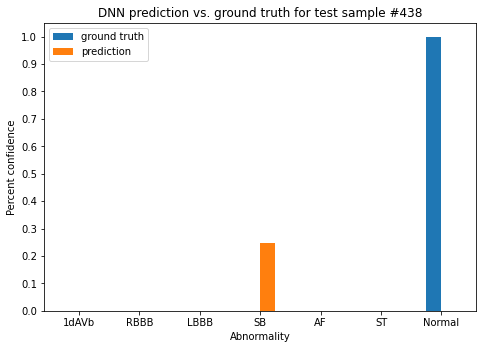

In [198]:
plot_prediction(438)

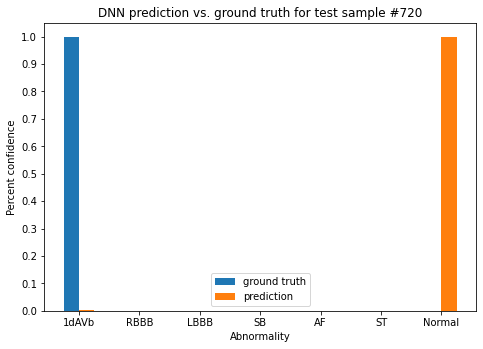

In [199]:
plot_prediction(720)